In [1]:
import numpy as np
from utils.normalize import HandcraftedFeaturePreprocessor
import matplotlib.pyplot as plt

import pandas as pd
import os, glob
import torch

from models.main import build_network
from preprocess import get_data

In [2]:
class Args:
    model='ae'
    r='./experiments/'
    z_dim=128
    in_dim=152
    data_pth='../data'
    batch_size=32
    outlier='none'
    hierClass='Stochastic'
    fold=0

args = Args()
if args.outlier!='none':
    job_name = '{}_{}_{}_fold{}'.format(args.model, args.hierClass, 
                                        args.outlier, args.fold)
else:
    job_name = '{}_{}_fold{}'.format(args.model, args.hierClass, args.fold)
args.directory = os.path.join(args.r, job_name)
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dataloader_train, dataloader_val, dataloader_test = get_data(args)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{0: 'AGN', 1: 'Blazar', 2: 'CV/Nova', 3: 'QSO', 4: 'YSO'}


In [4]:
class_dict = {0: 'AGN', 1: 'Blazar', 2: 'CV/Nova', 3: 'QSO', 4: 'YSO'}

In [5]:
unl_data = pd.read_parquet('../data_raw/features_20210719.parquet')

In [6]:
model_pth = os.path.join(args.directory, 'trained_parameters.pth')
state_dict = torch.load(model_pth)
model = build_network(args).to(args.device)
model.load_state_dict(state_dict)
model.eval()
if args.model in ['deepsvdd', 'classvdd']:
    model.set_c(dataloader_train)

In [7]:
n_det1 = []
n_det2 = []
data = []
labels = []
for oid, x, y, _ in dataloader_test:
    data.append(x)
    labels.extend([class_dict[i.item()] for i in y])
    features = unl_data[unl_data.index.isin(list(oid))].loc[list(oid)]
    n_det1.extend(features.n_det_1.to_list())
    n_det2.extend(features.n_det_2.to_list())
data = torch.cat(data)
labels = np.array(labels)

In [8]:
scores = []
with torch.no_grad():
    data = data.float().to(args.device)

    score = model.compute_anomaly_score(data)
    scores.append(score)
scores = torch.cat(scores).cpu().numpy()

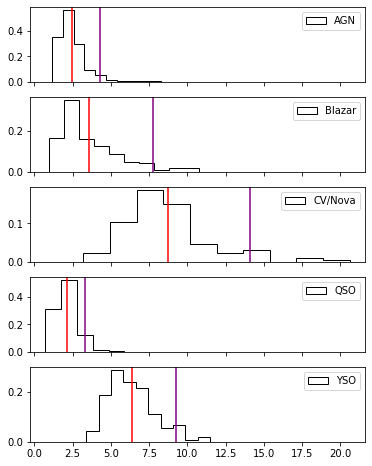

In [9]:
fig, axs = plt.subplots(len(class_dict), 1, sharex=True, figsize=(6, 8))
for key, label in class_dict.items():    
    scr = scores[labels==label]
    mean = np.mean(scr)
    percentile = np.percentile(scr, 95)
    axs[key].hist(scr, density=True, histtype='step', color='k', label=label)
    axs[key].axvline(mean, color='r')
    axs[key].axvline(percentile, color='purple')
    axs[key].legend()
plt.show()

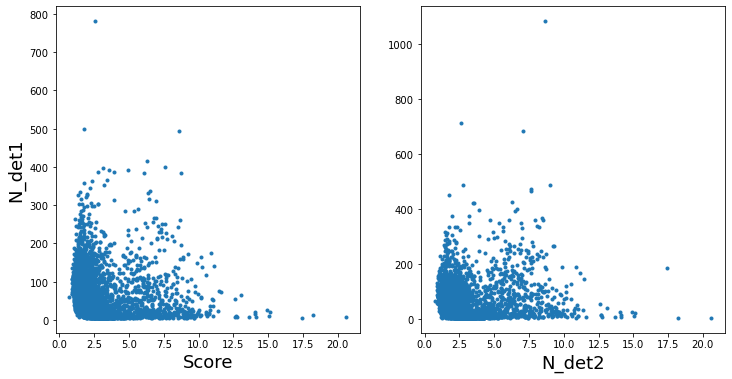

In [10]:
fix, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True)
axs[0].plot(scores, n_det1, '.')
axs[0].set_xlabel('Score', fontsize=18)
axs[0].set_ylabel('N_det1', fontsize=18)

axs[1].plot(scores, n_det2, '.')
axs[1].set_xlabel('N_det2', fontsize=18)
plt.show()